In [1]:
import numpy as np
from tqdm import tqdm
from scipy import ndimage, misc, stats
from time import clock_gettime, CLOCK_MONOTONIC
import cv2
import matplotlib.pyplot as plt
import os
from itertools import product
from skimage import feature
import hashlib

sha = lambda a: hashlib.sha256(a.tobytes()).hexdigest()

# Загрузка данных

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0048/2011_09_26_drive_0048_sync.zip

In [ ]:
!unzip -q 2011_09_26_drive_0048_sync.zip

In [4]:
img_1 = cv2.imread('2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000008.png', cv2.IMREAD_UNCHANGED)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)

img_2 = cv2.imread('2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000010.png', cv2.IMREAD_UNCHANGED)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)

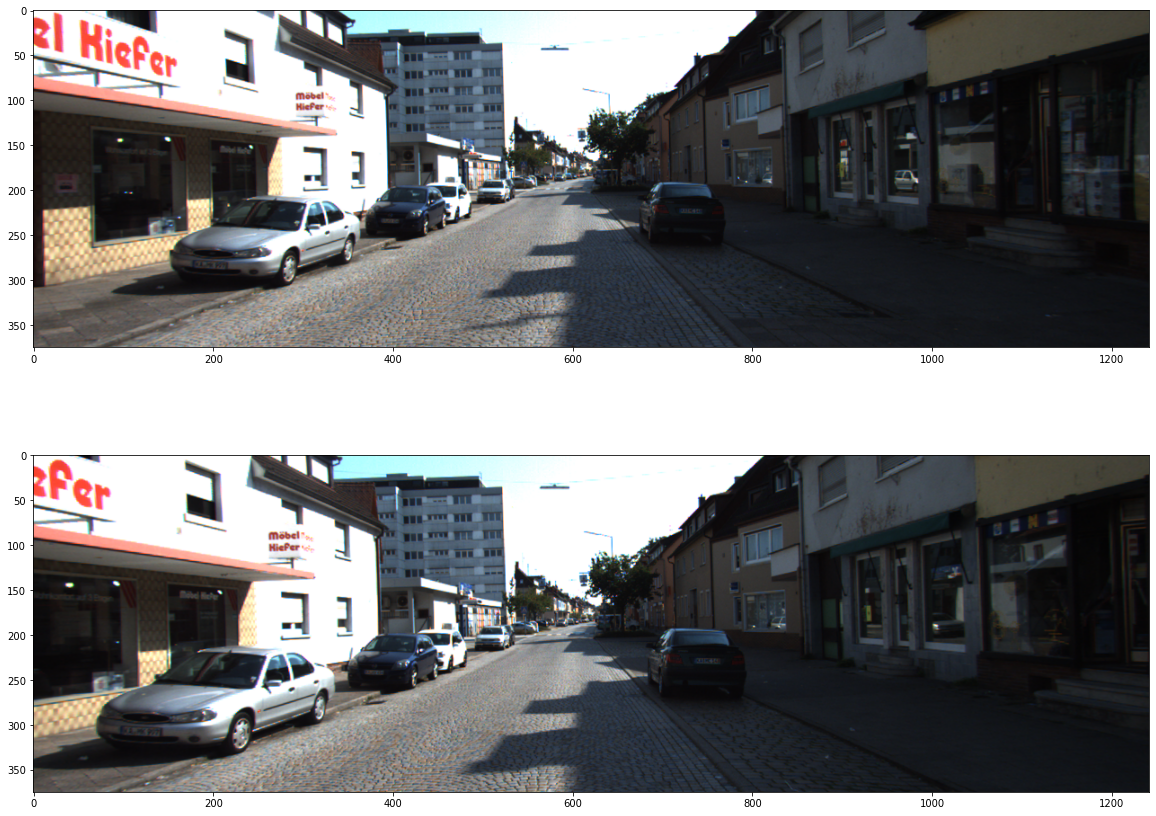

In [5]:
plt.figure(figsize=[20, 15])
plt.subplot(2, 1, 1)
plt.imshow(img_1)
plt.subplot(2, 1, 2)
plt.imshow(img_2)

# Извлечение ключевых точек

In [6]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp_1, des_1 = orb.detectAndCompute(img_1, None)
kp_2, des_2 = orb.detectAndCompute(img_2, None)

Каждая ключевая точка характеризуется:
1. angle - углом, что позволяет вычислять дескрипторы, инвариантные к повороту,
2. octave - октавой, определяющей масштаб, на котором была обнаружена ключевая точка,
3. pt - субпиксельными координатами этой ключевой точки на изображении, 
4. response - величиной отклика детектора,
5. size - размером (для визуализации величины отклика)

In [7]:
print('type(kp_1) =', type(kp_1))
print('len(kp_1) =', len(kp_1))
print()
print('kp_1[0] =', kp_1[0])
print()
print('kp_1[0].angle = ', kp_1[0].angle)
print('kp_1[0].octave = ', kp_1[0].octave)
print('kp_1[0].pt = ', kp_1[0].pt)
print('kp_1[0].response = ', kp_1[0].response)
print('kp_1[0].size = ', kp_1[0].size)

type(kp_1) = <class 'list'>
len(kp_1) = 500

kp_1[0] = <KeyPoint 0x7f59ae687a50>

kp_1[0].angle =  227.78240966796875
kp_1[0].octave =  0
kp_1[0].pt =  (736.0, 51.0)
kp_1[0].response =  0.003354368032887578
kp_1[0].size =  31.0


Дескрипторы - это вектора фиксированной длины для каждой ключевой точки

In [8]:
print('type(des_1) =', type(des_1))
print('des_1.shape =', des_1.shape)
print('des_1.dtype =', des_1.dtype)

type(des_1) = <class 'numpy.ndarray'>
des_1.shape = (500, 32)
des_1.dtype = uint8


In [9]:
img_1_kp = cv2.drawKeypoints(img_1, kp_1, None, (255, 0, 0), 4)

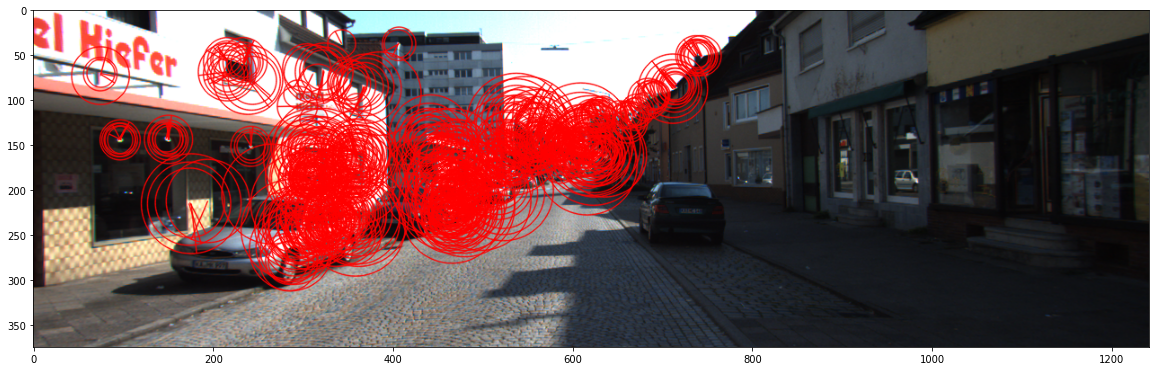

In [10]:
plt.figure(figsize=[20, 15])
plt.imshow(img_1_kp)

# Вопрос 1

О чем говорит наличие концентрических окружностей?

**Ответ:** Это множетсвенное детектирование, которое возникает в окресности какой-то сильный ключевой точки.

# Вопрос 2

Каким способом можно избавиться от избыточных близких ключевых точек? И нужно ли это делать?

**Ответ:** non-maximum supression, либо отсекать по некоторому заданному порогу.

# Сопоставление ключевых точек

In [11]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
matches = matcher.match(des_1, des_2)

matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:20]

In [12]:
img_matches = cv2.drawMatches(img_1, kp_1, img_2, kp_2, matches, None, flags=2)

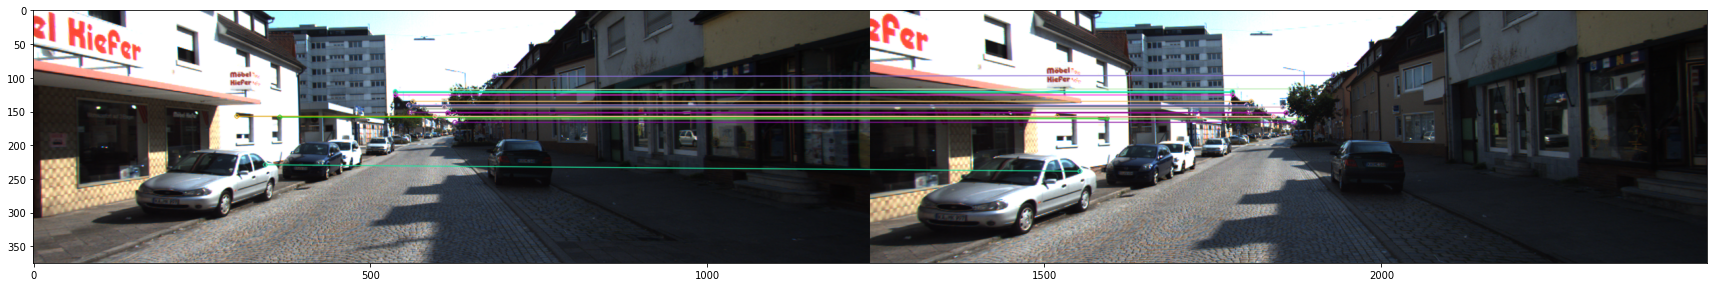

In [13]:
plt.figure(figsize=[30, 15])
plt.imshow(img_matches)

# Выравнивание изображений

In [14]:
src_pts = np.float32([ kp_1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [15]:
img_1_transformed = cv2.warpPerspective(img_1, M, (1242, 375))

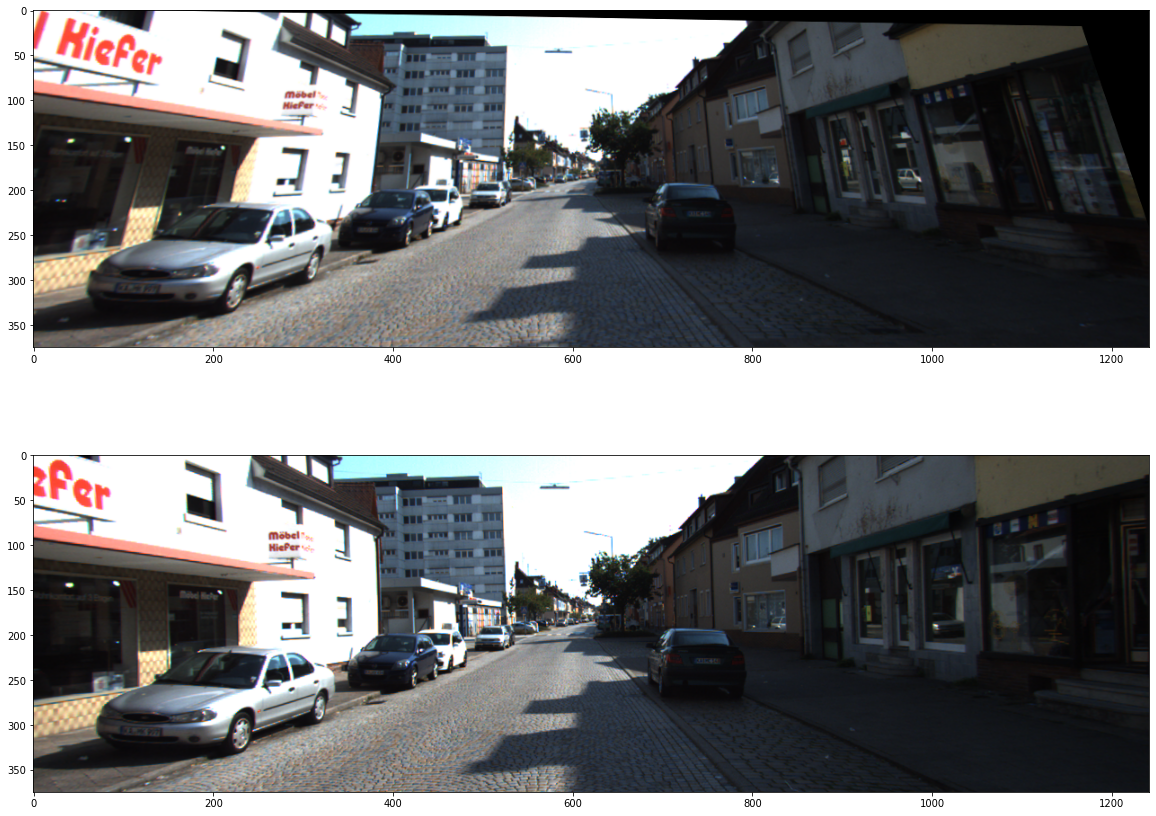

In [16]:
plt.figure(figsize=[20, 15])
plt.subplot(2, 1, 1)
plt.imshow(img_1_transformed)
plt.subplot(2, 1, 2)
plt.imshow(img_2)

# Реализация SURF

Основным заданием будет ознакомиться со статьей по [SURF](https://lirias.kuleuven.be/retrieve/78517) и дополнить недостающие строчки кода. Во многих местах достаточно одной строки, реализующих ту или иную математическую операцию на numpy.

Сначала ознакомьтесь со вспомогательными функциями:

In [17]:
def integral_image(image):
    '''Вычисляет интегральное изображение
    '''
    return image.cumsum(axis=0).cumsum(axis=1)


def partial_sums(integral, x, y, w, h, kernel_size, spatial_step):
    '''Вычисляет свертку изображения на основе интегрального изображения.
    Ядро свертки имеет размер kernel_size x kernel_size и движется
    с шагом spatial_step.
    
    По изображению движется ядро размера kernel_size x kernel_size
    с шагом spatial_step. Это ядро состоит из нулей, кроме прямоугольника
    с верхним левым углом (x, y) и размерами (ширина, высота) = (w, h).
    '''
    H, W = integral.shape[:2]
    integral = np.pad(integral, 1)
    x, y = x + 1, y + 1

    y1 = y - 1
    y2 = H - (kernel_size - y1) + 1
    x1 = x - 1
    x2 = W - (kernel_size - x1) + 1
    b1 = integral[y1:y2:spatial_step, x1:x2:spatial_step]

    y1 = y - 1
    y2 = H - (kernel_size - y1) + 1
    x1 = x + w - 1
    x2 = W - (kernel_size - x1) + 1
    b2 = integral[y1:y2:spatial_step, x1:x2:spatial_step]

    y1 = y + h - 1
    y2 = H - (kernel_size - y1) + 1
    x1 = x - 1
    x2 = W - (kernel_size - x1) + 1
    b3 = integral[y1:y2:spatial_step, x1:x2:spatial_step]

    y1 = y + h - 1
    y2 = H - (kernel_size - y1) + 1
    x1 = x + w - 1
    x2 = W - (kernel_size - x1) + 1
    b4 = integral[y1:y2:spatial_step, x1:x2:spatial_step]

    return b4 - b2 - b3 + b1

# Задание 1 Вспомогательные функции

Допишите оператор return в тех функциях, где это необходимо.

In [18]:
def Dx(integral, kernel_size):
    '''Первая производная по X
    '''
    left = partial_sums(integral, 0, 0, kernel_size // 2, kernel_size, kernel_size, 1)
    right = partial_sums(integral, kernel_size // 2, 0, kernel_size // 2, kernel_size, kernel_size, 1)
    return right - left


def Dy(integral, kernel_size):
    '''Первая производная по Y
    '''
    up = partial_sums(integral, 0, 0, kernel_size, kernel_size // 2, kernel_size, 1)
    bottom = partial_sums(integral, 0, kernel_size // 2, kernel_size, kernel_size // 2, kernel_size, 1)
    return bottom - up


def Dxx(integral, kernel_size, spatial_step):
    '''Вторая производная по X
    '''
    shift = round(kernel_size * 2 / 9)
    h = kernel_size - 2 * shift

    w1 = round(kernel_size / 3)
    w2 = round(kernel_size / 3)
    w3 = kernel_size - w1 - w2

    c1 = (3 * 5) / (w1 * h)
    c2 = (3 * 5) / (w2 * h)
    c3 = (3 * 5) / (w3 * h)

    left = partial_sums(integral, 0, shift, w1, h, kernel_size, spatial_step)
    center = partial_sums(integral, 0 + w1, shift, w2, h, kernel_size, spatial_step)
    right = partial_sums(integral, 0 + w1 + w2, shift, w3, h, kernel_size, spatial_step)

    return c1 * left - c2 * 2 * center + c3 * right


def Dyy(integral, kernel_size, spatial_step):
    '''Вторая производная по Y
    '''
    shift = round(kernel_size * 2 / 9)
    w = kernel_size - 2 * shift

    h1 = round(kernel_size / 3)
    h2 = round(kernel_size / 3)
    h3 = kernel_size - h1 - h2

    c1 = (3 * 5) / (h1 * w)
    c2 = (3 * 5) / (h2 * w)
    c3 = (3 * 5) / (h3 * w)

    top = partial_sums(integral, shift, 0, w, h1, kernel_size, spatial_step)
    center = partial_sums(integral, shift, 0 + h1, w, h2, kernel_size, spatial_step)
    bottom = partial_sums(integral, shift, 0 + h1 + h2, w, h3, kernel_size, spatial_step)

    return c1 * top - c2 * 2 * center + c3 * bottom


def Dxy(integral, kernel_size, spatial_step):
    '''Смешанная производная по XY
    '''
    shift_1 = round(kernel_size * 1 / 9)
    shift_2 = round(kernel_size * 5 / 9)
    size = round(kernel_size * 3 / 9)

    c = (3 * 3) / (size * size)

    b11 = partial_sums(integral, shift_1, shift_1, size, size, kernel_size, spatial_step)
    b21 = partial_sums(integral, shift_1, shift_2, size, size, kernel_size, spatial_step)
    b12 = partial_sums(integral, shift_2, shift_1, size, size, kernel_size, spatial_step)
    b22 = partial_sums(integral, shift_2, shift_2, size, size, kernel_size, spatial_step)

    return c * (b11 - b12 - b21 + b22)


def det_H_approx(integral, kernel_size, spatial_step):
    '''Приближенное значение определителя гессиана
    '''
    Dxx_image = Dxx(integral, kernel_size, spatial_step)
    Dyy_image = Dyy(integral, kernel_size, spatial_step)
    Dxy_image = Dxy(integral, kernel_size, spatial_step)
    return Dxx_image * Dyy_image - (0.9 *  Dxy_image)**2


def haar_approx(integral, kernel_size):
    Dx_image = Dx(integral, kernel_size)
    Dy_image = Dy(integral, kernel_size)
    return np.stack((Dx_image, Dy_image), axis=0)

Проверьте правильность реализации:

In [19]:
img_test = img_1_gray[:100, :100]
integral = integral_image(img_test)

a = Dx(integral, 9)
assert(a.shape == (92, 92))
assert(sha(a) == 'a13ca5983010a0fe5e86a11f413504277b23190d1ad3ec70fe48d10feabe12b3')

a = Dy(integral, 9)
assert(a.shape == (92, 92))
assert(sha(a) == 'bdacbf0ad8653a769b5e3dc96c5bc34a3527e35196675823b9ef483087166022')

a = Dxx(integral, 9, 2)
assert(a.shape == (46, 46))
assert(sha(a) == '2daecae029e754ec91b919762808afe0d4d9c21f3ec1823855e7a2f5305eeeff')

a = Dyy(integral, 9, 2)
assert(a.shape == (46, 46))
assert(sha(a)== 'de3967e10e78e28c504c4260a1d10f64f4ef7dca629ee2629ede1f4837b33b41')

a = Dxy(integral, 9, 2)
assert(a.shape == (46, 46))
assert(sha(a) == '294a0a784319d0caa9080ddc20fae40ed1be5c0875ce74dfd8abe8407b0419c8')

a = det_H_approx(integral, 9, 2)
assert(a.shape == (46, 46))
assert(sha(a) == '639f6e0a65539f83d680fcc39947cde6bd41030b53b15da9eac10135bcce254e')

# Задание 1 Детектор ключевых точек

1. В функции _init_pyramid заполните параметры пирамиды изображений правильными значениями
2. Релизуйте функцию _is_maxima, проверяющую, что центральный элемент кубика N27 размера 3x3x3, является максимальными среди всех элементов N27
3. Допишите функцию _interpolate_keypoint, вычисляющую положение субпиксельного максимума в N27

In [20]:
class FastHessianDetector:

    def __init__(self, hessian_threshold, n_octaves=4, n_octave_layers=2):
        self.hessian_threshold = hessian_threshold
        self.n_octaves = n_octaves
        self.n_octave_layers = n_octave_layers
        self.pyramid = None

        self.pyramid_internal_layers = []
        self.pyramid_parameters = []
        self._init_pyramid()

    def detect(self, image):
        pyramid = self._build_pyramid(image.astype(np.float32))

        keypoints = []
        for internal_layer in self.pyramid_internal_layers:
            layer_keypoints = self._extract_layer_keypoints(pyramid, internal_layer)
            keypoints.extend(layer_keypoints)

        return keypoints

    def _init_pyramid(self):
        index = 0
        prev_scale = 0
        for octave in range(self.n_octaves):
            for layer in range(self.n_octave_layers + 2):
                kernel_size = 9 * 2**octave + 6 * layer * 2**octave
                spatial_step = 2**octave
                scale = 1.2 * kernel_size * spatial_step / 9.
                scale_step = 1.2 * 6 * spatial_step * 2**octave / 9.
                self.pyramid_parameters.append((kernel_size, spatial_step, scale, scale_step))
                if 0 < layer <= self.n_octave_layers:
                    self.pyramid_internal_layers.append(index)
                index += 1
                prev_scale = scale
            
    def _build_pyramid(self, image):
        padding = (max([kernel_size for kernel_size, spatial_step, scale, scale_step in self.pyramid_parameters]) - 1) // 2
        imgage_padded = np.pad(image, padding)

        integral = integral_image(imgage_padded)
        H, W = integral.shape

        pyramid = []
        for kernel_size, spatial_step, scale, scale_step in self.pyramid_parameters:
            empty_size = padding - (kernel_size - 1) // 2
            pyramid_layer = det_H_approx(
                integral[empty_size:H - empty_size, empty_size:W - empty_size],
                kernel_size,
                spatial_step
            )
            pyramid.append(pyramid_layer)

        return pyramid

    def _extract_layer_keypoints(self, pyramid, internal_layer):
        H, W = pyramid[internal_layer].shape

        layer_keypoints = []
        maximas = []
        for y in range(1, H - 1):
            for x in range(1, W - 1):
                N27 = self._get_N27(pyramid, internal_layer, x, y)
                magnitude = N27[1, 1, 1]
                if self._is_maxima(N27) and magnitude >= self.hessian_threshold:
                    status, local_keypoint = self._interpolate_keypoint(N27)
                    if status:
                        keypoint = self._project_keypoint(local_keypoint, internal_layer, x, y)
                        layer_keypoints.append(keypoint)
                        maximas.append(magnitude)
        layer_keypoints = [layer_keypoints[i] for i in np.argsort(maximas)[::-1]]
        return layer_keypoints

    def _get_N27(self, pyramid, internal_layer, x, y):
        l = internal_layer
        N27 = np.array([[
            [pyramid[l - 1][y - 1, x - 1], pyramid[l - 1][y - 1, x], pyramid[l - 1][y - 1, x + 1]],
            [pyramid[l - 1][y, x - 1],     pyramid[l - 1][y, x],     pyramid[l - 1][y, x + 1]],
            [pyramid[l - 1][y + 1, x - 1], pyramid[l - 1][y + 1, x], pyramid[l - 1][y + 1, x + 1]]
        ], [
            [pyramid[l][y - 1, x - 1], pyramid[l][y - 1, x], pyramid[l][y - 1, x + 1]],
            [pyramid[l][y, x - 1],     pyramid[l][y, x],     pyramid[l][y, x + 1]],
            [pyramid[l][y + 1, x - 1], pyramid[l][y + 1, x], pyramid[l][y + 1, x + 1]]
        ], [
            [pyramid[l + 1][y - 1, x - 1], pyramid[l + 1][y - 1, x], pyramid[l + 1][y - 1, x + 1]],
            [pyramid[l + 1][y, x - 1],     pyramid[l + 1][y, x],     pyramid[l + 1][y, x + 1]],
            [pyramid[l + 1][y + 1, x - 1], pyramid[l + 1][y + 1, x], pyramid[l + 1][y + 1, x + 1]]
        ]])
        return N27

    def _is_maxima(self, N27):
        if N27[1, 1, 1] == np.amax(N27) and len(np.where(N27 == N27[1, 1, 1])[0]) == 1:                              
            return True
        else:
            return False

    def _interpolate_keypoint(self, N27):
        dL_dx = self._gradient(N27)
        d2L_d2x = self._hessian(N27)
        try:
            local_keypoint = np.linalg.solve(d2L_d2x, - dL_dx)
            status = (np.abs(local_keypoint) <= 1).all()
        except np.linalg.LinAlgError:
            local_keypoint = None
            status = False
        return status, local_keypoint

    def _first_derivative(self, N27, axis):
        index_0, index_2 = [1, 1, 1], [1, 1, 1]
        index_0[axis] = 0
        index_2[axis] = 2
        index_0, index_2 = tuple(index_0), tuple(index_2)
        return (N27[index_2] - N27[index_0]) / 2

    def _gradient(self, N27):
        return np.array([self._first_derivative(N27, axis) for axis in range(3)])

    def _second_derivative(self, N27, axes):
        if axes[0] == axes[1]:
            return self._double_derivative(N27, axes[0])
        else:
            return self._mixed_derivative(N27, axes)

    def _double_derivative(self, N27, axis):
        index_0, index_2 = [1, 1, 1], [1, 1, 1]
        index_0[axis] = 0
        index_2[axis] = 2
        index_0, index_2 = tuple(index_0), tuple(index_2)
        return N27[index_2] - 2 * N27[1, 1, 1] + N27[index_0]

    def _mixed_derivative(self, N27, axes):
        index_0_0, index_2_0 = [1, 1, 1], [1, 1, 1]
        index_0_0[axes[0]] = 0
        index_2_0[axes[0]] = 2
        index_0_0[axes[1]] = index_2_0[axes[1]] = 0
        index_0_0, index_2_0 = tuple(index_0_0), tuple(index_2_0)

        index_0_2, index_2_2 = [1, 1, 1], [1, 1, 1]
        index_0_2[axes[0]] = 0
        index_2_2[axes[0]] = 2
        index_0_2[axes[1]] = index_2_2[axes[1]] = 2
        index_0_2, index_2_2 = tuple(index_0_2), tuple(index_2_2)

        return ((N27[index_2_2] - N27[index_0_2]) - (N27[index_2_0] - N27[index_0_0])) / 4

    def _hessian(self, N27):
        return np.array([
            self._second_derivative(N27, axes) for axes in product(range(3), repeat=2)
        ]).reshape(3, 3)

    def _project_keypoint(self, local_keypoint, internal_layer, x, y):
        kernel_size, spatial_step, scale, scale_step = self.pyramid_parameters[internal_layer]
        local_scale, local_x, local_y = local_keypoint

        scale = scale + local_scale * scale_step
        x = (x + local_x + 0.5) * spatial_step
        y = (y + local_y + 0.5) * spatial_step

        return [scale, x, y]

Проверьте правильность реализации:

In [21]:
detector = FastHessianDetector(1000000)

img_test = img_1_gray[:100, :100]

keypoints = detector.detect(img_test)

a = np.array(keypoints)
assert(a.shape == (54, 3))
assert(sha(a) == '9e7f9abd638a7123fb44591ba1ba29ae89bcc22c6c256462603164f496ef016c')

# Задание 2 Оценка ориентации ключевых точек

1. В функции _init_pyramid заполните параметры пирамиды изображений правильными значениями
2. В функции _estimate_orientation допишите расчет радиуса окресности точки (2.a) и параметров нормального распределения (2.b), задающего вес точек в этой окрестности, через масштаб, на котором обнаружена ключевая точка, а также допишите вычисление нормы градиента (2.c).

In [22]:
class OrientationEstimator:

    def __init__(self, n_octaves=4, n_octave_layers=2):
        self.n_octaves = n_octaves
        self.n_octave_layers = n_octave_layers

        self.pyramid_parameters = []
        self._init_pyramid()

    def _init_pyramid(self):
        for octave in range(self.n_octaves):
            for layer in range(self.n_octave_layers + 2):
                kernel_size = 9 * 2**octave + 6 * layer * 2**octave
                spatial_step = 2**octave
                scale = 1.2 * kernel_size * spatial_step / 9.
                kernel_size = int(4 * scale)
                kernel_size += kernel_size % 2
                self.pyramid_parameters.append((scale, kernel_size))

    def estimate(self, image, keypoints):
        pyramid = self._build_pyramid(image.astype(np.float32))

        oriented_keypoints = []
        for keypoint in keypoints:
            orientation = self._estimage_orientation(pyramid, keypoint)
            oriented_keypoints.append((keypoint + [orientation]))

        return oriented_keypoints
    
    def _build_pyramid(self, image):
        padding = max([kernel_size for scale, kernel_size in self.pyramid_parameters]) // 2
        imgage_padded = np.pad(image, padding)

        integral = integral_image(imgage_padded)
        H, W = integral.shape

        pyramid = []
        for scale, kernel_size in self.pyramid_parameters:
            empty_size = padding - kernel_size // 2
            pyramid_layer = haar_approx(
                integral[empty_size:H - empty_size, empty_size:W - empty_size],
                kernel_size
            )
            pyramid.append(pyramid_layer)

        return pyramid
    
    def _estimage_orientation(self, pyramid, keypoint):
        scale, x, y = keypoint
        layer = self._find_nearest_layer(scale)
        Dx_image, Dy_image = pyramid[layer]

        center = int(x), int(y)
        radius = 6 * scale

        Dx_polar = cv2.linearPolar(Dx_image, center, radius, cv2.WARP_FILL_OUTLIERS)
        Dy_polar = cv2.linearPolar(Dy_image, center, radius, cv2.WARP_FILL_OUTLIERS)

        Dx_polar = ndimage.interpolation.zoom(Dx_polar, (360 / Dx_polar.shape[0], int(radius) / Dx_polar.shape[1]))
        Dy_polar = ndimage.interpolation.zoom(Dy_polar, (360 / Dy_polar.shape[0], int(radius) / Dy_polar.shape[1]))

        sigma = 2.5 * scale
        gauss_kernel = stats.norm(scale=sigma).pdf(np.arange(0, int(radius)))
        Dx_polar = (Dx_polar * gauss_kernel).sum(axis=1)
        Dy_polar = (Dy_polar * gauss_kernel).sum(axis=1)
        
        Dx_polar = np.concatenate((Dx_polar, Dx_polar[:60]), axis=0)
        Dy_polar = np.concatenate((Dy_polar, Dy_polar[:60]), axis=0)

        Dx_polar_cm = Dx_polar.cumsum(axis=0)
        Dy_polar_cm = Dy_polar.cumsum(axis=0)

        Dx_sum = Dx_polar_cm[60:] - Dx_polar_cm[:-60]
        Dy_sum = Dy_polar_cm[60:] - Dy_polar_cm[:-60]

        grad_norm = np.sqrt(Dx_sum**2 + Dy_sum**2)

        orientation = (np.argmax(grad_norm) + 30) % 360

        return orientation
    
    def _find_nearest_layer(self, scale):
        layer = min([(np.abs(scale - s), layer) 
            for layer, (s, _) in enumerate(self.pyramid_parameters)])[1]
        return layer

Проверьте правильность реализации:

In [23]:
estimator = OrientationEstimator()

oriented_keypoints = estimator.estimate(img_test, keypoints)

a = np.array(oriented_keypoints)
assert(a.shape == (54, 4))
assert(sha(a) == '7fc347618419629e7c16326f99c42f8d0d7b4edd6523d20977b080dd6525b985')

# Задание 3 Формирование SURF дескриптора

В функции вычисления дескриптора сформируйте:
1. src - квадрат, размером window_size x window_size, центром (x, y), повернутый на угол, задаваемый ориентацией ключевой точки
2. sigma - параметр нормального распределения, определяющего веса градиентов в окрестности точки
3. Dx_image, Dy_image - перевзвешенные градиетны с гауссовыми весами
4. Сохранение дескриптора

In [24]:
class SURFDescriptor:

    def compute(self, image, keypoints):
        descriptors = []
        for scale, x, y, orientation in keypoints:
            kernel_size = int(2 * scale)
            kernel_size += kernel_size % 2
            window_size = int(20 * scale)
            window_size += 4 - window_size % 4

            u = np.cos(np.pi * orientation / 180), np.sin(np.pi * orientation / 180)
            v = np.sin(np.pi * orientation / 180), - np.cos(np.pi * orientation / 180)
            dst = np.array([[0, 0], [0, window_size], [window_size, window_size], [window_size, 0]], dtype=np.float32)
            src = dst @ np.array([u, v]).T * scale
            src[:, 0] += x
            src[:, 1] += y
            src = np.array(src, dtype=np.float32)
            M = cv2.getPerspectiveTransform(src, dst)

            patch = cv2.warpPerspective(image, M, (window_size, window_size))
            patch = np.pad(patch, kernel_size // 2)

            integral = integral_image(patch)
            Dx_image = Dx(integral, kernel_size)[:-1, :-1]
            Dy_image = Dy(integral, kernel_size)[:-1, :-1]

            sigma = 3.3 * scale      
            gauss_kernel = stats.norm(scale=sigma).pdf(np.arange(-window_size//2, (window_size+1)//2))
            Dx_image = Dx_image * gauss_kernel
            Dy_image = Dy_image * gauss_kernel

            descriptor = []
            for i in range(4):
                for j in range(4):
                    i1, i2 = i * window_size // 4, (i + 1) * window_size // 4
                    j1, j2 = j * window_size // 4, (j + 1) * window_size // 4
                    dx = Dx_image[i1:i2, j1:j2].sum()
                    dy = Dy_image[i1:i2, j1:j2].sum()
                    dx_abs = np.abs(Dx_image[i1:i2, j1:j2]).sum()
                    dy_abs = np.abs(Dy_image[i1:i2, j1:j2]).sum()
                    descriptor.extend([dx, dy, dx_abs, dy_abs])
            descriptor = np.array(descriptor)
            descriptors.append(descriptor)                                                                                     


        return descriptors

In [25]:
extractor = SURFDescriptor()

descriptors = extractor.compute(img_test, oriented_keypoints)

a = np.array(descriptors)
assert(a.shape == (54, 64))
assert(sha(a) == '2330cbd6e7998a22fbed1ff39702a1bd304205a6b59943ac4529d04156278e13')

AssertionError: ignored

# FastHessianDetector + OrientationEstimator + SURFDescriptor

In [26]:
def detect_and_draw(img):
    print('Image resolution:', img.shape)
    detector = FastHessianDetector(1000000)
    estimator = OrientationEstimator()
    extractor = SURFDescriptor()

    start = clock_gettime(CLOCK_MONOTONIC)
    keypoints = detector.detect(img)
    end = clock_gettime(CLOCK_MONOTONIC)
    print('Keypoint extraction:', end - start, 's')

    start = clock_gettime(CLOCK_MONOTONIC)
    oriented_keypoints = estimator.estimate(img, keypoints)
    end = clock_gettime(CLOCK_MONOTONIC)
    print('Keypoint orientation estimation:', end - start, 's')

    start = clock_gettime(CLOCK_MONOTONIC)
    descriptors = extractor.compute(img, oriented_keypoints)
    end = clock_gettime(CLOCK_MONOTONIC)
    print('Descriptor extraction:', end - start, 's')
    print()

    kps = [cv2.KeyPoint(kp[1], kp[2], kp[0], kp[3]) for kp in oriented_keypoints]
    img_kps = cv2.drawKeypoints(img, kps, None, (255, 0, 0), 4)

    return img_kps, kps, np.array(descriptors, dtype=np.float32)

In [27]:
img_kp, kp, des = detect_and_draw(img_1_gray)

Image resolution: (375, 1242)
Keypoint extraction: 24.65398023599846 s
Keypoint orientation estimation: 22.148537762997876 s
Descriptor extraction: 20.291071224000916 s



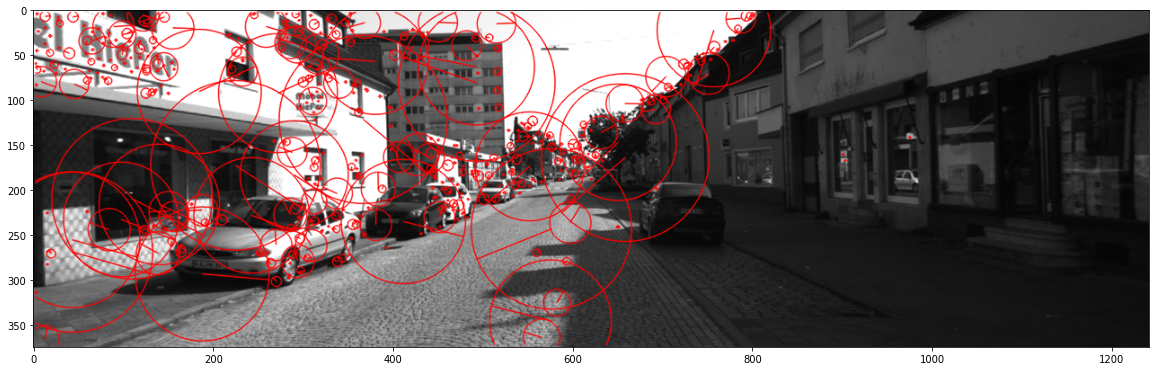

In [28]:
plt.figure(figsize=[20, 15])
plt.imshow(img_kp)